##Fetch dataset from sklearn

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

###Divide actual data from target

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
X.iloc[0,:]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

###Plot a single picture

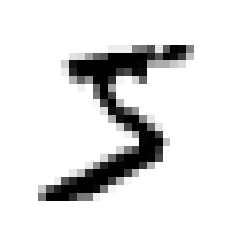

corresponding label  5


In [5]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np

example = np.array(X.iloc[0,:])
example_image = example.reshape(28,28)

plt.imshow(example_image, cmap = mlp.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

print("corresponding label ", y[0])

###Split train-test

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##Simplify the problem
Let's only detect if a given number is a "5" or not. Binary classification

In [7]:
y_train_5 = y_train == "5" #true for all 5's
y_test_5 = y_test == "5"

###Training a Binary Classifier

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Let's detect the "example" image, which is a "5"


In [9]:
sgd_clf.predict([example])

array([ True])

##Measuring Accuracy using cross validation

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy" )

array([0.95035, 0.96035, 0.9604 ])

Accuracy above 96%, seems great! But wait , let's also create a dummy classifier that classifies every image as "not 5"


###Dummy classifier

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self,X, y = None):
    return self

  def predict(self,X):
    return np.zeros((len(X), 1), dtype=bool)

In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy" )

array([0.91125, 0.90855, 0.90915])

Also this dummy classifier has a great performance! What is happening !? 
The accuracy metric is not good for this dataset because there are a few "5"'s and to many "not 5". So if I guess "not 5" every time I expect to have a great acuracy (90%).

In this case the confusion matric can be very helpful.


##Confusion Matrix

[[52316  2263]
 [  601  4820]]


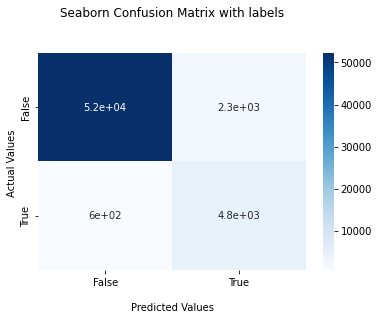

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_train_pred = sgd_clf.predict(X_train)
cf_matrix = confusion_matrix(y_train_5, y_train_pred)

print(cf_matrix)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

each row of the confusion matrix represents an actual class , while each column represents a predicted class. A perfect classifier would have only true positives and true negatives

##Precision , Recall and F1

sometimes you need to evaluate your model with precision and recall or f=F1 metrics 
 
![](https://i.stack.imgur.com/7QIRU.gif)

In [14]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) , recall_score(y_train_5, y_train_pred)

(0.6805026118876183, 0.8891348459693783)

Doesn't seem great as before now that we have both precision and recall. Sometimes is conviniente to aggregate these metrics, in the F1 score

In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7709532949456175

And that is easy to interpret: The **desion function** tells us on which side of the hyperplane generated by the classifier we are (and how far we are away from it). Then based on a threshold we can classigy the scores as 0s or 1s.
Lets compute these scores

In [19]:
from sklearn.model_selection import cross_val_predict

y_score = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 2, method = "decision_function" )

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thesholds = precision_recall_curve(y_train_5, y_score)
precisions, recalls, thesholds

(array([0.09084511, 0.09082987, 0.09083139, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-94829.16072226, -94823.85614805, -94685.04293961, ...,
         56431.32026464,  57711.40130606,  60085.47378044]))

###Plot Precision Recall curve 

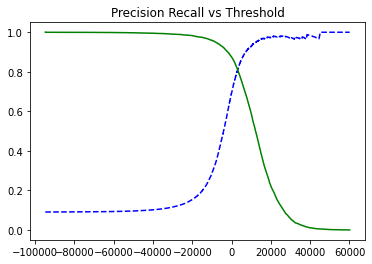

<Figure size 640x480 with 0 Axes>

In [32]:
def plot_precision_recall_vs_threshold(precisions:float, recalls:float, threshold:float) -> None:
  plt.plot(threshold, precisions[:-1], "b--", label = "Precision")
  plt.plot(threshold, recalls[:-1], "g-", label = "Recall")
  plt.title("Precision Recall vs Threshold")


plot_precision_recall_vs_threshold(precisions, recalls, thesholds)
plt.show()

A good threshold to use for our predictions can be in the intersect of the curves.
It can be also useful to directly plot the precision vs the recall, and choose a tradeoff in this way

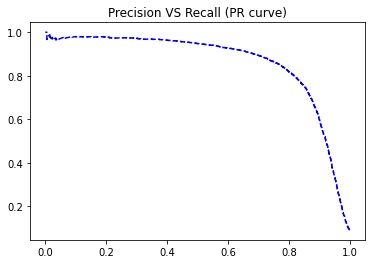

In [43]:
plt.plot(recalls[:-1], precisions[:-1], "b--")
plt.title("Precision VS Recall (PR curve)")
plt.show()

##ROC Curve

Common tool used in binary classification. Plots the **true positive rate** (recall) against the **false positive rate**.

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_score)
fpr, tpr, threshold

(array([0.        , 0.        , 0.        , ..., 0.99400868, 0.99400868,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 5.34956650e-03, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  60086.47378044,   60085.47378044,   45173.46260834, ...,
         -94823.85614805,  -94829.16072226, -194705.69122635]))

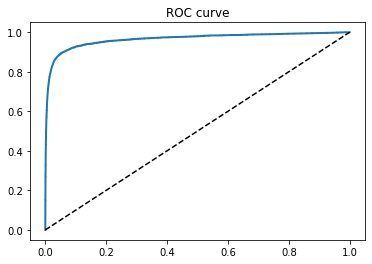

In [39]:
def plot_roc_curve(fpr:np.array , tpr:np.array, label:str=None) -> None:
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1],[0,1],"k--")

plot_roc_curve(fpr,tpr)
plt.title("ROC curve")
plt.show()

The dotted line represents the ROC curve of a purely random classifier. One way to compare classifiers is to measure the area under the curve (**AUC**). A perfect AUC score is equal to 1.

In [42]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_train_5, y_score)
print("AUC score : ", auc)

AUC score :  0.9650460216920477


You should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. The ROC curve othewise.

##Comparison of 2 algoritmhs using ROC curve

Remember some algorithms, instead of decision_function have predict_proba

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")

To plot a roc curve we need score, not probabilities. A simple solution is to use the positive class's probabilities as the score

In [61]:
y_score_forest = y_probas_forest[:,1] #score = proba of positive classes
fpr_foest, tpr_forest, treshold_forest = roc_curve(y_train_5, y_score_forest)

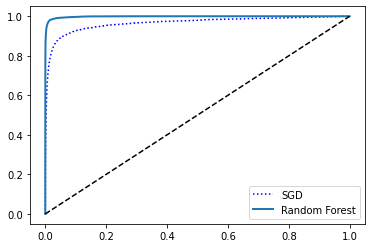

In [62]:
plt.plot(fpr,tpr, "b:", label = "SGD")
plot_roc_curve(fpr_foest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

Radnom forest looks better!